## Imports

In [1]:
# Standard library imports
import os
import random
import pickle

# Data analysis packages
import numpy as np
import pandas as pd
from scipy.signal import correlate, correlation_lags
from scipy.ndimage import gaussian_filter1d

# Visualization packages
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyArrow, Patch, Circle
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D

# Image processing packages
import imageio
from PIL import Image, ImageSequence

# Braingeneers packages for analysis
import braingeneers
import braingeneers.data.datasets_electrophysiology as ephys
from braingeneers.analysis.analysis import SpikeData, read_phy_files, load_spike_data, burst_detection, randomize_raster

## Data

In [2]:
with open('/workspaces/human_hippocampus/dev/other/thomas/thesis/pickled_datasets/propagation_dataset.pkl', 'rb') as file:
    sd = pickle.load(file)

## Functional Connectivity Map Code

In [18]:
# Function to get neuron positions
def get_neuron_positions(spike_data):
    # Extract neuron positions from spike_data
    neuron_x = []
    neuron_y = []
    for neuron in spike_data.neuron_data['positions'].values():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])
    neuron_positions = np.array([neuron_x, neuron_y]).T
    return neuron_positions

def calculate_mean_firing_rates(spike_data):
    mean_firing_rates = []
    for neuron_spikes in spike_data.train:
        num_spikes = len(neuron_spikes)
        time_duration = spike_data.length / 1000  # Assuming spike times are in milliseconds
        firing_rate = num_spikes / time_duration
        mean_firing_rates.append(firing_rate)

    return np.array(mean_firing_rates)

def latencies_mean_neuron(lat_list):
    """
    Output: Returns a list containing the mean latencies for each sublist.
    Input: lat_list- A list of lists representing latencies between a particular neuron, x, and all others. Created with `sd.latencies_to_index(x)`
    """
    nested_list = lat_list
    for i in range(len(nested_list)):
        sublist = nested_list[i]
        length = len(sublist)
        if length == 0:
            sublist_mean = 0
        else:
            sublist_mean = sum(sublist)/len(sublist)
            sublist_mean = round(sublist_mean, 3) # Round to 3d.p.
        nested_list[i] = sublist_mean
    return nested_list

def latencies_mean_all(sd):
    """
    Output: Returns a list of lists containing the mean latencies between all neurons
    Input: sd- A SpikeData object, the standard data format for braingeneers
    """
    latencies_array = [None] * sd.N
    for curr_neuron in range(sd.N):
        latencies = latencies_mean_neuron(sd.latencies_to_index(curr_neuron))
        latencies_array[curr_neuron] = latencies # Store mean latency in corresponding position of 'latencies_array2'
    return latencies_array

def get_in_out_degree( mean_latency_matrix ): 
    """
    Output: Returns a list of tuples, [(incoming,outgoing),....] , containing the in and out degree for each neuron. 
            This is the number of "receicer" and "sender" signals the neurons get from other neurons
    Input: mean_latency_matrix- A list of lists containing the mean latency between all neurons
    """
    in_out_deg = [(0, 0) for _ in range(len(mean_latency_matrix))]
    for curr_neuron in range(len(mean_latency_matrix)):
        in_deg = 0
        out_deg = 0
        curr_neural_latencies = mean_latency_matrix[curr_neuron]
        for i in range(len(curr_neural_latencies)):
            if curr_neural_latencies[i] > 0:
                out_deg += 1
            if curr_neural_latencies[i] < 0:
                in_deg += 1
        in_out_deg[curr_neuron] = (in_deg, out_deg)
    return in_out_deg

def label_sender_receiver_neurons(in_out_deg, latency_thresh=0.2):
    node_info = ['grey'] * len(in_out_deg)
    for i in range(len(in_out_deg)):
        if (in_out_deg[i][1] + in_out_deg[i][0]) == 0:
            test1 = 0
            test2 = 0
        else:
            test1 = (in_out_deg[i][1] - in_out_deg[i][0]) / (in_out_deg[i][1] + in_out_deg[i][0])
            test2 = (in_out_deg[i][0] - in_out_deg[i][1]) / (in_out_deg[i][1] + in_out_deg[i][0])
        
        if test1 > latency_thresh:
            node_info[i] = 'red'
        elif test2 > latency_thresh:
            node_info[i] = 'blue'
    return node_info

def plot_functional_connectivity_map( sd, latency_threshold=.1, show_sttc=True,  sttc_threshold=.1):
    """
    Output: plots the functional connectivity map, displayin "sender" and ""receiver" neurons in the neural circuit
    Inputs:
        sd (SpikeData object)- the standard data format for braingeneers
        latency_threshold (float)- Between 0-1. The threshold for the fraction of in/out signals a neuron must have to be labelled a "sender" or "receiver"
        show_sttc (boolean)- If True, the spike time tiling connections between neurons are also plotted
        sttc_threshold (float)- Between 0-1. The strength a spike time tiling correlation must be above in order to be plotted
    """
    # Plot functional connectivity map
    print("calculating all latencies...")
    all_mean_latencies = latencies_mean_all(sd)
    in_out_deg = get_in_out_degree(all_mean_latencies)
    sender_receiver_neurons = label_sender_receiver_neurons(in_out_deg, latency_threshold )
    print("making plot")
    neuron_x = []
    neuron_y = []
    for neuron in sd.neuron_data['positions'].values():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])
    plt.figure(figsize=(8,8))
    plt.scatter(neuron_x, neuron_y, c=sender_receiver_neurons)
    # Plot legend for functional connectivity map
    node_type_legend_elements = [
    plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='grey', label='Broker'),
    plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='red', label='Sender'),
    plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='blue', label='Receiver')
    ]
    node_type_legend = plt.legend(handles=node_type_legend_elements, title='Node Type', loc='best')
    plt.gca().add_artist(node_type_legend)
    plt.title("Functional Connectivity Map - Synthetic Wave-Propagation Data")
    plt.xlabel('X position')
    plt.ylabel('Y position')

    # Plot spike time tiling connections between neurons
    if show_sttc:
        sttc = sd.spike_time_tilings(delt=40)
        for i in range(sttc.shape[0]):
            for j in range(sttc.shape[1]):
                if i <= j: continue
                if sttc[i,j] < sttc_threshold : continue
                ix,iy = sd.neuron_data['positions'][i]['position']
                jx,jy = sd.neuron_data['positions'][j]['position']
                # ix,iy = sd.neuron_data[0][i]['position']
                # jx,jy = sd.neuron_data[0][j]['position']
                linewidth = 1.5 + 2 * (sttc[i, j] - sttc_threshold)
                opacity = 0.2 + 0.8 * (sttc[i, j] - sttc_threshold)  # Modify opacity based on correlation
                # Plot line between the points with linewidth and opacity
                plt.plot([ix, jx], [iy, jy], linewidth=linewidth, c='grey', alpha=opacity)
        # Create legend for spike time tilings
        correlation_legend_elements = [
            plt.Line2D([0], [0], color='grey', linewidth=0.5, label='0.6'),
            plt.Line2D([0], [0], color='grey', linewidth=1.0, label='0.8'),
            plt.Line2D([0], [0], color='grey', linewidth=1.5, label='1.0')
        ]
        correlation_legend = plt.legend(handles=correlation_legend_elements, title='Correlation', loc='lower left')
        plt.gca().add_artist(correlation_legend)
    
    # Invert y axis to match the image
    plt.gca().invert_yaxis()

    # Make x and y axis equal
    plt.axis('equal')

    plt.show()

In [5]:
sd2 = sd.subtime(0, 10000)

calculating all latencies...
making plot


/tmp/ipykernel_13408/2637027774.py:102: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data['positions'].values():
/tmp/ipykernel_13408/2637027774.py:126: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  ix,iy = sd.neuron_data['positions'][i]['position']
/tmp/ipykernel_13408/2637027774.py:127: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  jx,jy = sd.neuron_data['positions'][j]['position']


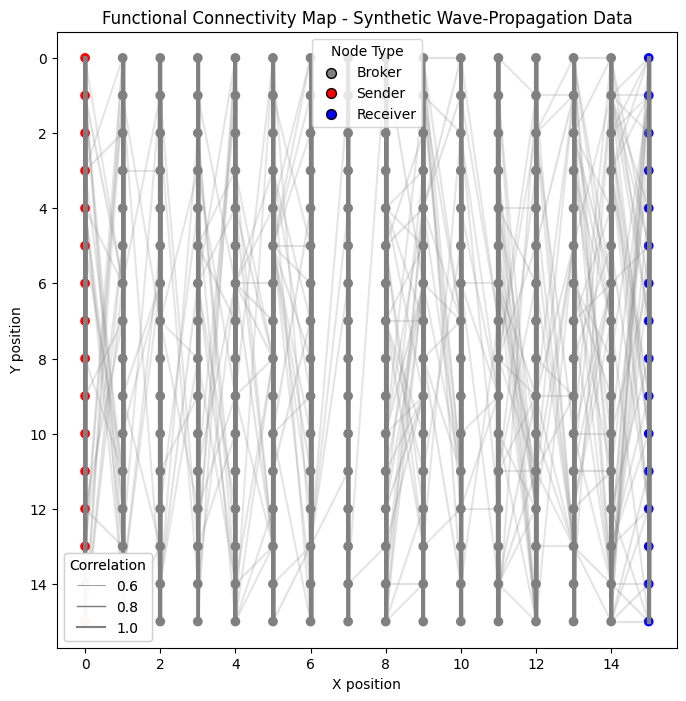

In [19]:
plot_functional_connectivity_map(sd, latency_threshold=.3, show_sttc=True,  sttc_threshold=.25)

In [10]:
os.getcwd()

'/workspaces/human_hippocampus/dev/other/thomas/thesis/synthetic'